In [1]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


/home/pkruyt/cernbox/xsuite-laser/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [2]:
from ion_properties import ions,lead,calcium,xenon

ion=calcium

In [3]:
for ion in [xenon] :# Ion properties:


        # Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0

        gamma = ion.gamma_rel4
        beta=  np.sqrt(1-1/(gamma*gamma))
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion.Intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

        line.particle_ref=particle_ref


        nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = 0.063 # m

        emittance=nemitt/(beta*gamma)

        num_particles=int(5e3)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()

        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                particle_ref=particle_ref,
                line=line_arc,        
                )

        particles0=particles.copy()
        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)
        print(sigma_dp)
        sigma_dp=2e-4  
        
        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion.excited_lifetime
        hw0 = ion.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = ion.lambda_l

        # # Shift laser wavelength for fast longitudinal cooling:5
        # lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3

        

        #sigma_t=sigma_t*0.70 # to get 1.9 ps
        # sigma_t=1.9e-12

        GF_IP = xt.PulsedLaser(
                        laser_x=0,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 0.6
        int_time_s = 0.01
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)

        # num_turns = int(1e3)
        # save_interval = num_turns/100
        # # save_interval=1

        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)


        # line.discard_tracker()
        # IP_index=16675   
        # line.insert_element('monitor', element=monitor, index=IP_index)
        # line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
        # SPS_line.append_element(monitor,'monitor')
        # SPS_line.append_element(GF_IP,'GF_IP')
        laser_x_list=np.linspace(-5*1e-3,5*1e-3,150)
        final_emittance_list = []
        final_dp_p=[]
        # cooler_growth_rates_list=[]
        # cooler_heating_growth_rates_list=[]
        transverse_growth_rate_list=[]
        longitudinal_growth_rate_list=[]

        from scipy.optimize import curve_fit

        plt.figure(figsize=(12, 8))
        plt.rcParams.update({'font.size': 25})

        for laser_x_loop in tqdm(laser_x_list):
        
                GF_IP.laser_x=laser_x_loop
                particles=particles0.copy()

                line = xt.Line(
                        elements=[monitor,GF_IP,arc])

                context = xo.ContextCpu(omp_num_threads=1)
                line.build_tracker(_context=context)
                # line.optimize_for_tracking()

                line.track(particles, num_turns=num_turns,
                        turn_by_turn_monitor=False,with_progress=True)

                # extract relevant values
                x = monitor.x[:,:,0]
                px = monitor.px[:,:,0]
                y = monitor.y[:,:,0]
                py = monitor.py[:,:,0]
                delta = monitor.delta[:,:,0]
                zeta = monitor.zeta[:,:,0]
                state = monitor.state[:,:,0]
                time = monitor.at_turn[:, 0, 0] * T_per_turn

                gamma_x=(1+alpha_x**2)/beta_x
                gamma_y=(1+alpha_y**2)/beta_y

                action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
                action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

                emittance_x=np.mean(action_x,axis=1)*gamma/2

                # Define the exponential function
                def exponential_func(x, a, b):
                        return a * np.exp(x * b)
                
                # Fit the data to the exponential function
                params_transverse, covariance = curve_fit(exponential_func, time, emittance_x)

                # Extract the parameters
                a, b = params_transverse

                transverse_growth_rate_list.append(b)

                final_emittance_list.append(emittance_x[-1])

                # plt.plot(time,emittance_x*1e6, linewidth=5.0)
                # plt.plot(time, exponential_func(time,
                # *params_transverse) * 1e6, linestyle='--')
                
                # Fit the data to the exponential function
                rms_dp_p = np.std(delta, axis=1)
                window_size = 10  # or any other suitable value
                rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')


                params_longitudinal, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)

                # Extract the parameters
                a, b = params_longitudinal

                longitudinal_growth_rate_list.append(b)

                final_dp_p.append(rms_dp_p[-1])


        np.savez(f'results/optimal_laser_x/{ion.name}.npz', transverse_growth_rate_list=transverse_growth_rate_list,
                longitudinal_growth_rate_list=longitudinal_growth_rate_list,final_dp_p=final_dp_p,
                final_emittance_list=final_emittance_list,laser_x_list=laser_x_list,nemitt=nemitt,time=time)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020136441750203603
Laser pulse duration sigma_t = 2.04 ps
Laser wavelength = 768.00 nm


  0%|          | 0/150 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  1%|          | 1/150 [00:28<1:11:16, 28.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  1%|▏         | 2/150 [00:56<1:10:02, 28.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  2%|▏         | 3/150 [01:23<1:07:42, 27.63s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  3%|▎         | 4/150 [01:49<1:05:18, 26.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  3%|▎         | 5/150 [02:14<1:03:39, 26.34s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  4%|▍         | 6/150 [02:41<1:03:59, 26.67s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  5%|▍         | 7/150 [03:08<1:03:42, 26.73s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  5%|▌         | 8/150 [03:35<1:03:13, 26.72s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  6%|▌         | 9/150 [04:02<1:03:18, 26.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  7%|▋         | 10/150 [04:30<1:03:03, 27.03s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  7%|▋         | 11/150 [04:56<1:02:11, 26.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  8%|▊         | 12/150 [05:21<1:00:30, 26.31s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  9%|▊         | 13/150 [05:46<59:21, 25.99s/it]  

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  9%|▉         | 14/150 [06:13<59:23, 26.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 10%|█         | 15/150 [06:41<59:56, 26.64s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 11%|█         | 16/150 [07:10<1:01:09, 27.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 11%|█▏        | 17/150 [07:40<1:02:41, 28.28s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 12%|█▏        | 18/150 [08:08<1:01:48, 28.10s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 13%|█▎        | 19/150 [08:37<1:01:48, 28.31s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 13%|█▎        | 20/150 [09:05<1:01:27, 28.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 14%|█▍        | 21/150 [09:32<59:56, 27.88s/it]  

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 15%|█▍        | 22/150 [10:00<59:49, 28.04s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 15%|█▌        | 23/150 [10:28<59:09, 27.95s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 16%|█▌        | 24/150 [10:56<58:44, 27.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 17%|█▋        | 25/150 [11:24<58:28, 28.06s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 17%|█▋        | 26/150 [11:54<58:40, 28.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 18%|█▊        | 27/150 [12:23<59:06, 28.83s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 19%|█▊        | 28/150 [12:53<59:13, 29.13s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 19%|█▉        | 29/150 [13:24<59:27, 29.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 20%|██        | 30/150 [13:53<58:55, 29.46s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 21%|██        | 31/150 [14:23<58:57, 29.73s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 21%|██▏       | 32/150 [14:54<58:55, 29.96s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 22%|██▏       | 33/150 [15:24<58:26, 29.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 23%|██▎       | 34/150 [15:56<59:26, 30.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 23%|██▎       | 35/150 [16:32<1:01:37, 32.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 24%|██▍       | 36/150 [17:03<1:00:24, 31.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 25%|██▍       | 37/150 [17:35<59:58, 31.85s/it]  

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 25%|██▌       | 38/150 [18:06<59:03, 31.64s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 26%|██▌       | 39/150 [18:37<58:00, 31.35s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 27%|██▋       | 40/150 [19:05<55:52, 30.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 27%|██▋       | 41/150 [19:27<50:39, 27.88s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 28%|██▊       | 42/150 [19:49<46:49, 26.02s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 29%|██▊       | 43/150 [20:10<44:02, 24.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 29%|██▉       | 44/150 [20:42<47:21, 26.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 30%|███       | 45/150 [21:13<49:23, 28.23s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 31%|███       | 46/150 [21:45<50:32, 29.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 31%|███▏      | 47/150 [22:19<52:30, 30.58s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 32%|███▏      | 48/150 [22:52<53:36, 31.54s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 33%|███▎      | 49/150 [23:25<53:34, 31.82s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 33%|███▎      | 50/150 [23:56<52:48, 31.68s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 34%|███▍      | 51/150 [24:29<52:50, 32.02s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 35%|███▍      | 52/150 [24:59<51:26, 31.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 35%|███▌      | 53/150 [25:30<50:23, 31.17s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 36%|███▌      | 54/150 [26:02<50:10, 31.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 37%|███▋      | 55/150 [26:35<50:47, 32.08s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 37%|███▋      | 56/150 [27:09<51:09, 32.65s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 38%|███▊      | 57/150 [27:41<49:59, 32.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 39%|███▊      | 58/150 [28:12<49:04, 32.00s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 39%|███▉      | 59/150 [28:48<50:11, 33.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 40%|████      | 60/150 [29:18<48:35, 32.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 41%|████      | 61/150 [29:50<47:29, 32.01s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 41%|████▏     | 62/150 [30:21<46:35, 31.77s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 42%|████▏     | 63/150 [30:52<45:53, 31.65s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 43%|████▎     | 64/150 [31:23<45:11, 31.53s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 43%|████▎     | 65/150 [31:56<45:17, 31.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 44%|████▍     | 66/150 [32:36<47:50, 34.18s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 45%|████▍     | 67/150 [33:16<49:55, 36.10s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 45%|████▌     | 68/150 [33:55<50:26, 36.91s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 46%|████▌     | 69/150 [34:36<51:16, 37.98s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 47%|████▋     | 70/150 [35:15<51:04, 38.30s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 47%|████▋     | 71/150 [35:55<51:05, 38.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 48%|████▊     | 72/150 [36:34<50:32, 38.88s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 49%|████▊     | 73/150 [37:14<50:20, 39.23s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 49%|████▉     | 74/150 [37:54<50:10, 39.62s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 50%|█████     | 75/150 [38:34<49:27, 39.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 51%|█████     | 76/150 [39:14<48:56, 39.68s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 51%|█████▏    | 77/150 [39:53<48:02, 39.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 52%|█████▏    | 78/150 [40:32<47:22, 39.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 53%|█████▎    | 79/150 [41:12<47:00, 39.72s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 53%|█████▎    | 80/150 [41:53<46:29, 39.85s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 54%|█████▍    | 81/150 [42:32<45:37, 39.67s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 55%|█████▍    | 82/150 [43:12<45:08, 39.83s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 55%|█████▌    | 83/150 [43:52<44:39, 39.99s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 56%|█████▌    | 84/150 [44:32<43:47, 39.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 57%|█████▋    | 85/150 [45:14<43:47, 40.42s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 57%|█████▋    | 86/150 [45:54<43:12, 40.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 58%|█████▊    | 87/150 [46:34<42:21, 40.34s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 59%|█████▊    | 88/150 [47:15<41:48, 40.46s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 59%|█████▉    | 89/150 [47:54<40:50, 40.17s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 60%|██████    | 90/150 [48:32<39:22, 39.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 61%|██████    | 91/150 [49:12<38:53, 39.55s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 61%|██████▏   | 92/150 [49:51<38:10, 39.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 62%|██████▏   | 93/150 [50:30<37:23, 39.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 63%|██████▎   | 94/150 [51:05<35:24, 37.93s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 63%|██████▎   | 95/150 [51:40<34:02, 37.14s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 64%|██████▍   | 96/150 [52:20<34:11, 37.98s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 65%|██████▍   | 97/150 [52:55<32:39, 36.96s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 65%|██████▌   | 98/150 [53:32<32:11, 37.14s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 66%|██████▌   | 99/150 [54:09<31:28, 37.02s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 67%|██████▋   | 100/150 [54:46<30:51, 37.04s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 67%|██████▋   | 101/150 [55:24<30:32, 37.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 68%|██████▊   | 102/150 [56:02<29:57, 37.44s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 69%|██████▊   | 103/150 [56:40<29:24, 37.54s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 69%|██████▉   | 104/150 [57:20<29:21, 38.30s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 70%|███████   | 105/150 [57:58<28:42, 38.28s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 71%|███████   | 106/150 [58:36<27:55, 38.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 71%|███████▏  | 107/150 [59:14<27:21, 38.18s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 72%|███████▏  | 108/150 [59:55<27:15, 38.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 73%|███████▎  | 109/150 [1:00:37<27:16, 39.92s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 73%|███████▎  | 110/150 [1:01:16<26:31, 39.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 74%|███████▍  | 111/150 [1:01:56<25:45, 39.64s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 75%|███████▍  | 112/150 [1:02:35<25:01, 39.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 75%|███████▌  | 113/150 [1:03:15<24:23, 39.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 76%|███████▌  | 114/150 [1:03:52<23:18, 38.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 77%|███████▋  | 115/150 [1:04:28<22:12, 38.06s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 77%|███████▋  | 116/150 [1:05:02<20:49, 36.76s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 78%|███████▊  | 117/150 [1:05:35<19:41, 35.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 79%|███████▊  | 118/150 [1:06:09<18:49, 35.28s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 79%|███████▉  | 119/150 [1:06:43<17:58, 34.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 80%|████████  | 120/150 [1:07:17<17:20, 34.67s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 81%|████████  | 121/150 [1:07:53<16:51, 34.87s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 81%|████████▏ | 122/150 [1:08:27<16:09, 34.61s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 82%|████████▏ | 123/150 [1:09:02<15:39, 34.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 83%|████████▎ | 124/150 [1:09:35<14:52, 34.34s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 83%|████████▎ | 125/150 [1:10:08<14:05, 33.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 84%|████████▍ | 126/150 [1:10:40<13:22, 33.45s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 85%|████████▍ | 127/150 [1:11:12<12:37, 32.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 85%|████████▌ | 128/150 [1:11:44<11:57, 32.61s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 86%|████████▌ | 129/150 [1:12:15<11:17, 32.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 87%|████████▋ | 130/150 [1:12:46<10:37, 31.87s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 87%|████████▋ | 131/150 [1:13:17<09:58, 31.53s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 88%|████████▊ | 132/150 [1:13:48<09:22, 31.24s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 89%|████████▊ | 133/150 [1:14:18<08:44, 30.85s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 89%|████████▉ | 134/150 [1:14:48<08:09, 30.62s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 90%|█████████ | 135/150 [1:15:18<07:35, 30.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 91%|█████████ | 136/150 [1:15:44<06:49, 29.26s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 91%|█████████▏| 137/150 [1:16:08<05:57, 27.52s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 92%|█████████▏| 138/150 [1:16:31<05:15, 26.28s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 93%|█████████▎| 139/150 [1:16:54<04:39, 25.37s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 93%|█████████▎| 140/150 [1:17:17<04:06, 24.67s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 94%|█████████▍| 141/150 [1:17:44<03:46, 25.21s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 95%|█████████▍| 142/150 [1:18:14<03:32, 26.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 95%|█████████▌| 143/150 [1:18:43<03:11, 27.29s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 96%|█████████▌| 144/150 [1:19:11<02:45, 27.54s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 97%|█████████▋| 145/150 [1:19:41<02:22, 28.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 97%|█████████▋| 146/150 [1:20:12<01:57, 29.26s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 98%|█████████▊| 147/150 [1:20:42<01:27, 29.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 99%|█████████▊| 148/150 [1:21:10<00:57, 28.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 99%|█████████▉| 149/150 [1:21:38<00:28, 28.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

100%|██████████| 150/150 [1:22:03<00:00, 32.82s/it]


<Figure size 1200x800 with 0 Axes>

Transverse emittance

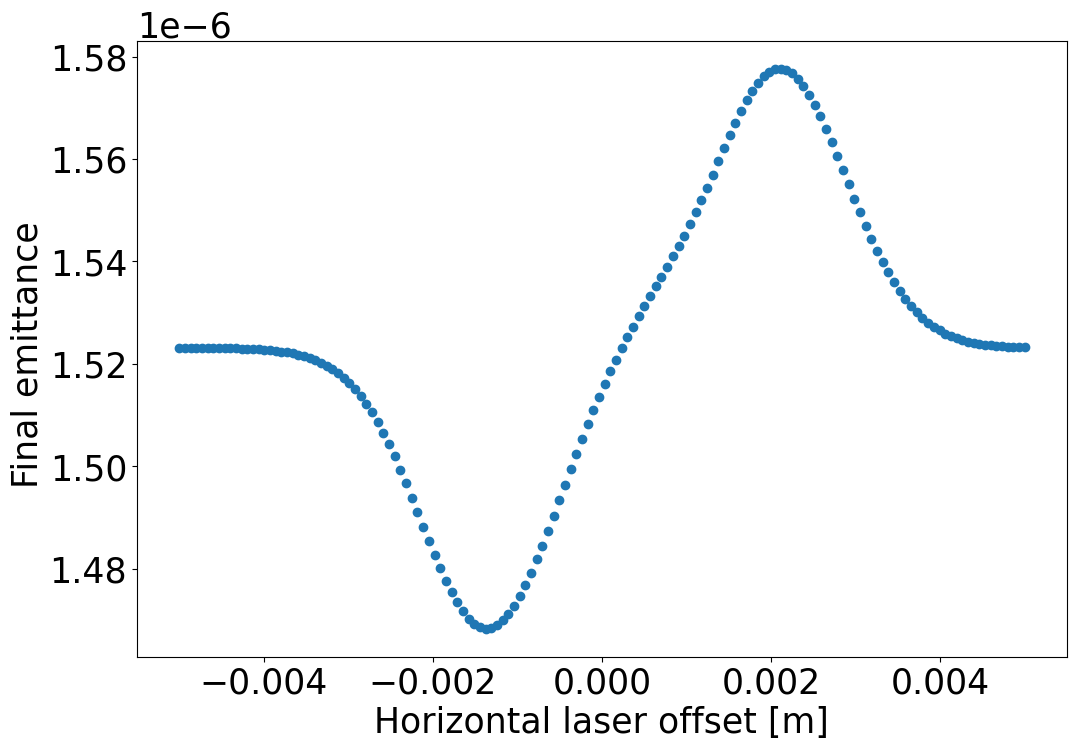

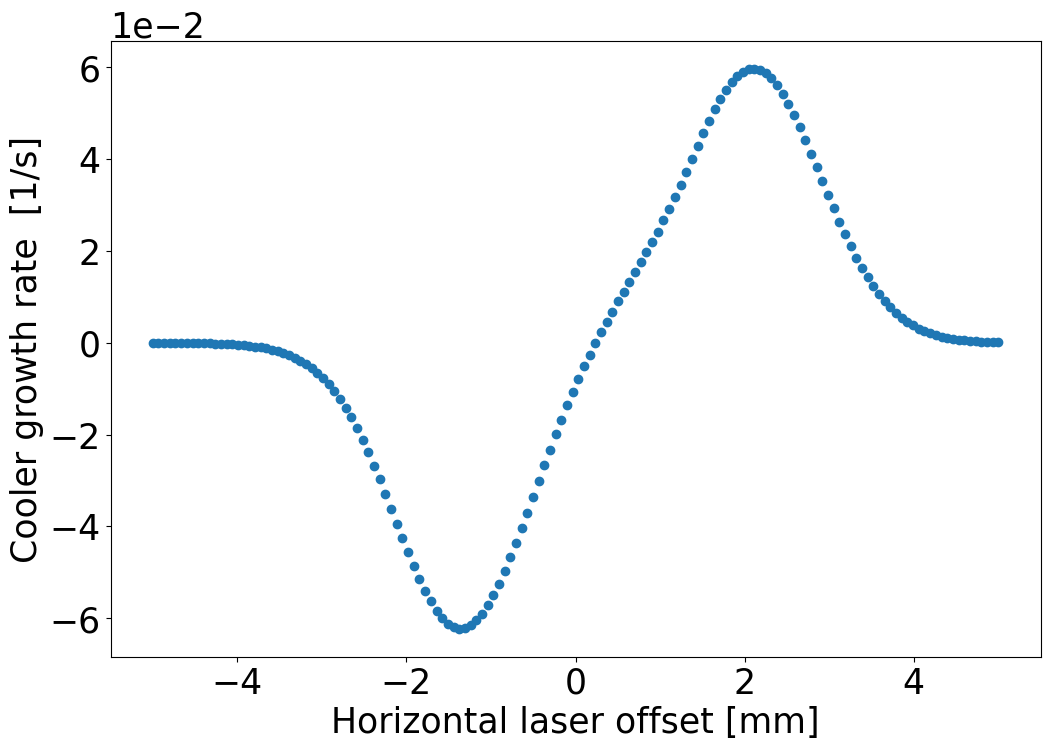

In [4]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list,final_emittance_list)
plt.xlabel('Horizontal laser offset [m]')
plt.ylabel('Final emittance ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list*1e3,transverse_growth_rate_list)
plt.xlabel('Horizontal laser offset [mm]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()